<h1 style="text-align: center;">CSCI 4968: Homework 3</h1>

<h2 style="text-align: center;">Question 1</h2>

$$\partial f(w,b) = \frac{1}{n}\sum_{i=1}^{n}\partial (1-y_i(w^Tx_i+b))_+ + \frac{\lambda}{2} \partial ||w||$$

We first find the sub-differential of $f(w,b)$ w.r.t. $w$ by apply affine transformation rule:

Let $h_i(w,b) = (1-y_i(w^Tx_i+b))_+ = (1-y_iw^Tx_i-y_ib)_+$, then we could apply the affine transformation rule to $h_i(w,b)$:

\begin{align*}
\partial h_i(w,b) &= -y_ix_i \cdot \partial p(z) |_{z=1-y_iw^Tx_i-y_ib} \text{ where } p(z) = z_+ = max(0,z).\\
&= -y_ix_i \cdot
\begin{cases}
    0 & 1-y_iw^Tx_i-y_ib < 0\\
    1 & 1-y_iw^Tx_i-y_ib > 0\\
    [0,1] & 1-y_iw^Tx_i-y_ib = 0\\
\end{cases}\\
\end{align*}

and we know $\frac{\lambda}{2}\partial_w ||w||^2_2 = \lambda w$

Thus, we have:$$\partial_w f = \frac{1}{n} \sum^n_{i=1} -y_ix_i \cdot
\begin{cases}
    0 & 1-y_iw^Tx_i-y_ib < 0\\
    1 & 1-y_iw^Tx_i-y_ib > 0\\
    [0,1] & 1-y_iw^Tx_i-y_ib = 0\\
\end{cases} + \lambda w$$

Next, we find the sub-differential of $f(w,b)$ w.r.t. $b$ by apply affine transformation rule:

Let $g_i(w,b) = (1-y_i(w^Tx_i+b))_+ = (1-y_iw^Tx_i-y_ib)_+$, then we could apply the affine transformation rule to $g_i(w,b)$:

\begin{align*}
\partial g_i(w,b) &= -y_i \cdot \partial p(z) |_{z=1-y_iw^Tx_i-y_ib} \text{ where } p(z) = z_+ = max(0,z).\\
&= -y_i \cdot
\begin{cases}
    0 & 1-y_iw^Tx_i-y_ib < 0\\
    1 & 1-y_iw^Tx_i-y_ib > 0\\
    [0,1] & 1-y_iw^Tx_i-y_ib = 0\\
\end{cases}\\
\end{align*}

and we know $\frac{\lambda}{2}\partial_b ||w||^2_2 = 0$

Thus, we have:$$\partial_b f = \frac{1}{n} \sum^n_{i=1} -y_i \cdot
\begin{cases}
    0 & 1-y_iw^Tx_i-y_ib < 0\\
    1 & 1-y_iw^Tx_i-y_ib > 0\\
    [0,1] & 1-y_iw^Tx_i-y_ib = 0\\
\end{cases}$$


In [26]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# %load_ext autotime

In [27]:
# ----------------------------------------- implementing SGD -------------------------------------
def subgradloss(x, y, w):
    """
    subgradloss calculates the subgradient on the loss function
    :param x: feature vector (dim = d)
    :param y: target label (dim = 1)
    :param w: weights w = (w, b) (dim = d+1)
    :return: subgradient on the loss function subgrad_w, concatenate with subgrad_b
    """
    w0 = np.array(w[:-1])
    b = w[-1]
    cond = 1 - y*w0.dot(x) - y*b

    if cond <= 0:
        grad_w = 0
        grad_b = 0
    else:
        grad_w = -y*x
        grad_b = -y

    return np.concatenate((np.full(w0.shape[0], grad_w), np.array([grad_b])))


def subgradreg(regparam, w):
    return regparam * w

# implement a stochastic subgradient descent solver function:
def sgdmethod(X, y, subgradloss, subgradreg, regparam, w1, T, a, m):
    w = w1.copy()
    omega = [w] # history of sgd
    n, d = X.shape

    for t in tqdm(range(T)):
        # Sample m training examples without replacement
        indices = np.random.choice(n, m, replace=False)
        X_batch, y_batch = X[indices], y[indices]
        for j in range(n//m):
            g_t = np.mean([subgradloss(X_batch[i], y_batch[i], w) for i in range(m)], axis=0)

            alpha_t = (1+a*t)**-1 # step size (dependent on t)
            w_next = omega[t][:-1] - alpha_t*(g_t[:-1] + subgradreg(regparam, omega[t][:-1])) # update w
            b_next = omega[t][-1] - alpha_t*g_t[-1] # update b
        omega.append(np.concatenate((w_next, np.array([b_next])))) # update history

    return omega

In [28]:
# ----------------------------------------- load data --------------------------------------------
X_train, y_train = datasets.load_svmlight_file("a9a")
X_train, y_train = np.asarray(X_train.todense()), np.asarray(y_train)
# remove the last column of x_train
X_train = X_train[:, :-1]
X_test, y_test = datasets.load_svmlight_file("a9a.t")
X_test, y_test = np.asarray(X_test.todense()), np.asarray(y_test)

# Create a scaler object and fit it to the training data
scaler = StandardScaler()
scaler.fit(X_train)

# Scale the training features
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
n_train, d_train = X_train.shape

In [29]:
# ----------------------------------- sgd with train data ----------------------------------------
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
lambda_const = 1/n_train
a_sgd = 0.07 # step size = pi/10 because I did this on March 14th
wi = np.ones(d_train+1)
# sgd (mini_batch sgd with batch_size = n_train)
sgd_out = sgdmethod(X_train, y_train, subgradloss, subgradreg, lambda_const, wi, 45, a_sgd, n_train)

100%|██████████| 45/45 [00:12<00:00,  3.70it/s]


100%|██████████| 46/46 [00:00<00:00, 850.45it/s]


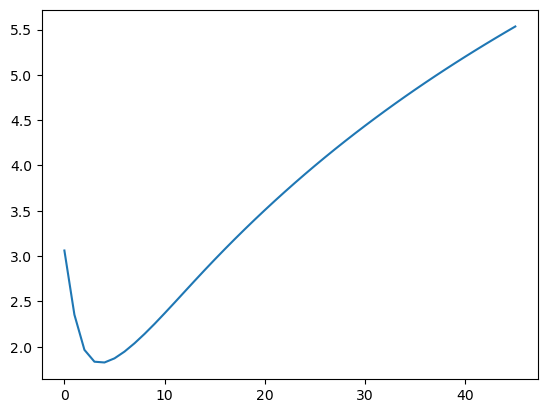

In [30]:
obj_hist_sgd = []
def find_objective_heler(w,b,X,y,reg_term):
    temp = 1-(np.multiply(y,(w.T@X.T+b)))
    temp[temp<0] = 0
    return (np.sum(temp)/X.shape[0])+ (reg_term/2)*(w.T@w)

def objectiveEval(w, X, y, lambda_const):
    sum = 0
    for i in range(len(y)):
        temp = 1 - y[i] * (w[:-1].dot(X[i]) + w[-1])
        sum += max(0, temp)
    return sum / len(y) + (lambda_const / 2) * np.linalg.norm(w[:-1], ord=2) ** 2


for i in tqdm(range(len(sgd_out))):
    obj_hist_sgd.append(find_objective_heler(sgd_out[i][0:-1],sgd_out[i][-1], X_train, y_train, lambda_const))

plt.plot(obj_hist_sgd)

In [31]:
# # ----------------------------------- sgd with batch size 1 ----------------------------------------
# lambda_const = 1/n_train
# a_minibatch_sgd = 0.0001
# wi = np.ones(d_train+1)
# # sgd (mini_batch sgd with batch_size = n_train)
# minibatch_sgd_out = sgdmethod(X_train, y_train, subgradloss, subgradreg, lambda_const, wi, 300, a_sgd, 1)
#
# obj_hist_minibatch_sgd = []
# for i in tqdm(range(len(minibatch_sgd_out))):
#     w = minibatch_sgd_out[i]
#     w0 = np.reshape(np.array(w[:-1]), (122, 1))
#     b = w[-1]
#     obj_hist_minibatch_sgd.append(np.mean([np.maximum(1-y_train[i]*(X_train[i]*w0+b), 0) for i in range(len(y_train))]) + lambda_const/2*np.linalg.norm(w0)**2)
#
# plt.plot(obj_hist_sgd)